In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from SCIGMA import *
from data import load_data, preprocessing
import numpy as np
import matplotlib.pyplot as plt
from utils import clustering
import scanpy as sc
import anndata

## Load and preprocess data

In [3]:
# Spatial-ATAC-RNA-seq data: download from https://zenodo.org/records/10362607 
rna = sc.read_h5ad('Mouse_Brain/adata_RNA.h5ad')
atac = sc.read_h5ad('Mouse_Brain/adata_peaks_normalized.h5ad')

In [4]:
# preprocess into dict
data_dict = preprocessing(rna, atac, datatype='Spatial-ATAC-RNA-seq',n_neighbors=18, feat_neighbors=6)

Preprocessing anndatas


/users/schang59/.conda/envs/SCIGMA/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


Constructing spatial graphs
Constructing feature graphs
Feature graph 1
Feature graph 1 finished
Feature graph 2
Feature graph 2 finished


## Train SCIGMA

In [5]:
seed = 5181
model = SCIGMA(data_dict, seed_num=seed, dim_output=40, device=torch.device('cuda:0'), recon_weight1=1, recon_weight2=1, contrastive_weight1=1e-2, contrastive_weight2=1e-2, clr_weight=0.3, batch_size=8000, learning_rate=1e-3)

Num samples pruned: 0
Creating adjacency matrices
Model ready for training!


In [6]:
output = model.train(600)

100%|██████████| 600/600 [21:54<00:00,  2.19s/it]


Model training finished!



In [7]:
adata_combined = rna.copy()
adata_combined.obsm['emb_latent_omics1'] = output['emb_latent_omics1']
adata_combined.obsm['emb_latent_omics2'] = output['emb_latent_omics2']
adata_combined.obsm['emb_combined'] = output['emb_latent_combined']
adata_combined.obsm['emb_recon_omics1'] = output['emb_recon_omics1']
adata_combined.obsm['emb_recon_omics2'] = output['emb_recon_omics2']
adata_combined.obs['invtau'] = output['invtau']
adata_combined.obs['tau'] = output['tau']
adata_combined.obsm['attention'] = output['attention']

## Spatial Domain Detection

In [8]:
# we use mcluster as clustering tool by default.
tool = 'mclust' # mclust, leiden, and louvain

# clustering
if tool == 'mclust':
    clustering(adata_combined, key='emb_combined', add_key='SCIGMA', n_clusters=17, method=tool, use_pca=False)
elif tool in ['leiden', 'louvain']:
    clustering(adata_combined, key='emb_combined', add_key='SCIGMA', n_clusters=17, method=tool, start=0.1, end=2.0, increment=0.01)

R[write to console]:     __  ___________    __  _____________
   /  |/  / ____/ /   / / / / ___/_  __/
  / /|_/ / /   / /   / / / /\__ \ / /   
 / /  / / /___/ /___/ /_/ /___/ // /    
/_/  /_/\____/_____/\____//____//_/    version 5.4.9
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


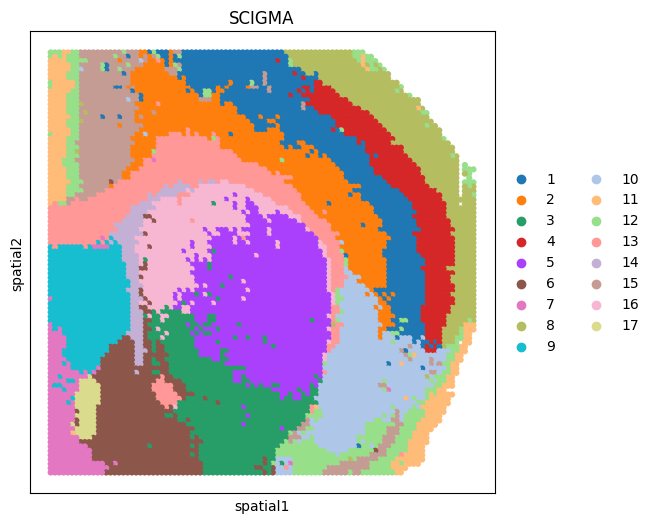

In [9]:
# visualization
import scanpy as sc
fig, ax_list = plt.subplots(1, 1, figsize=(6, 6))
sc.pl.embedding(adata_combined, basis='spatial', color='SCIGMA', ax=ax_list, title='SCIGMA', s=80, show=False)
plt.gca()
plt.show()

/users/schang59/.conda/envs/SCIGMA/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


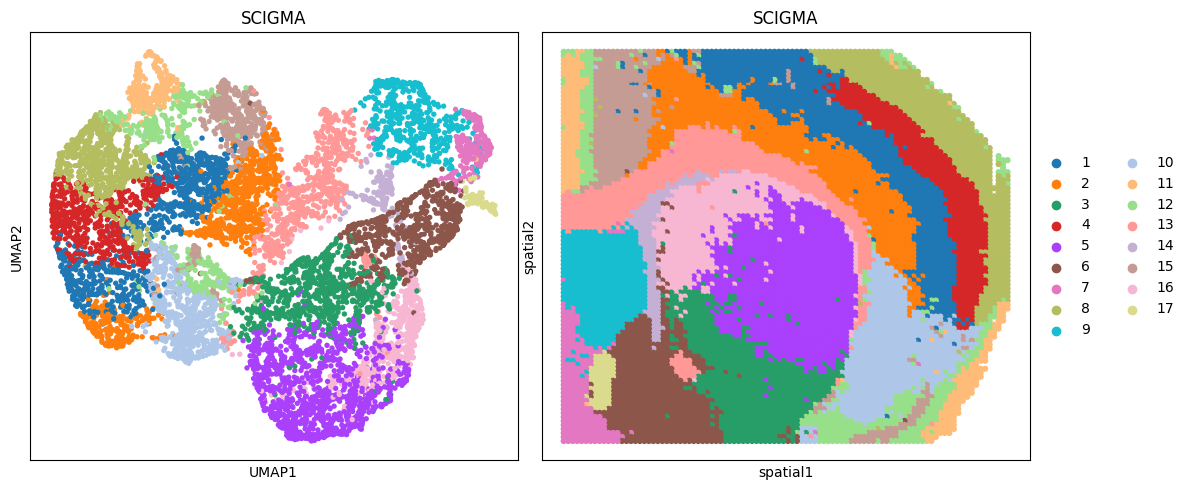

In [10]:
# visualization
fig, ax_list = plt.subplots(1, 2, figsize=(12, 5))
sc.pp.neighbors(adata_combined, use_rep='emb_combined', n_neighbors=10)
sc.tl.umap(adata_combined)

sc.pl.umap(adata_combined, color='SCIGMA', ax=ax_list[0], title='SCIGMA', s=60, show=False)
sc.pl.embedding(adata_combined, basis='spatial', color='SCIGMA', ax=ax_list[1], title='SCIGMA', s=80, show=False)

ax_list[0].get_legend().remove()
plt.tight_layout(w_pad=0.3)
plt.show()

## Uncertainty Value Visualization

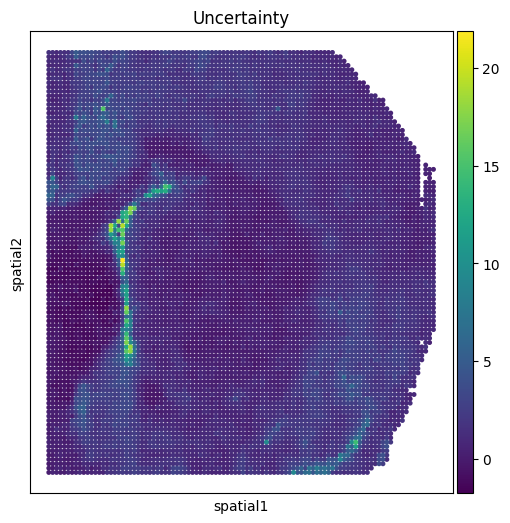

In [13]:
# uncertainty visualization
fig, ax_list = plt.subplots(1, 1, figsize=(6, 6))
sc.pl.embedding(adata_combined, 
                basis='spatial', 
                color=['invtau'], 
                title=['Uncertainty'], 
                ax=ax_list,
                s=50, show=False)
plt.gca()
plt.show()